# Samples 1a (pristine) 3 (high defect): figures

This notebook compares sample 3 (high defect density) with sample 1a (pristine). The end results are two plots of 2D diffraction scans of the two samples plotted on the same colour scale.

The notebook makes use of some standard python module as well as the `shem_spot_profile` module available on [Github](https://github.com/slambrick/SHeM-diffraction-analysis). The notebook supports the publication "Defect density quantification in monolayer MoS<sub>2</sub> using helium atom micro-diffraction".

In [1]:
import numpy as np
import SHeM_diffraction_analysis.shem_spot_profile as ssp
import scipy
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from scipy import optimize
import pandas as pd
from scipy.interpolate import splrep, BSpline
import os

out_dir = "figures_output"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Import data

The partial 2D scan for sample 3 @200C is loaded and plotted below.

Normalising against alpha = 60.0


/home/sam/repositories/mos2-defects/SHeM_diffraction_analysis/shem_spot_profile.py:1080: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh1 = ax1.pcolormesh(sP.alpha*pi/180, getattr(sP, var), Z,


(<Figure size 800x600 with 3 Axes>,
 <PolarAxes: xlabel='$\\alpha$'>,
 <Axes: ylabel='$\\log_{10}(I/\\mathrm{nA})$'>)

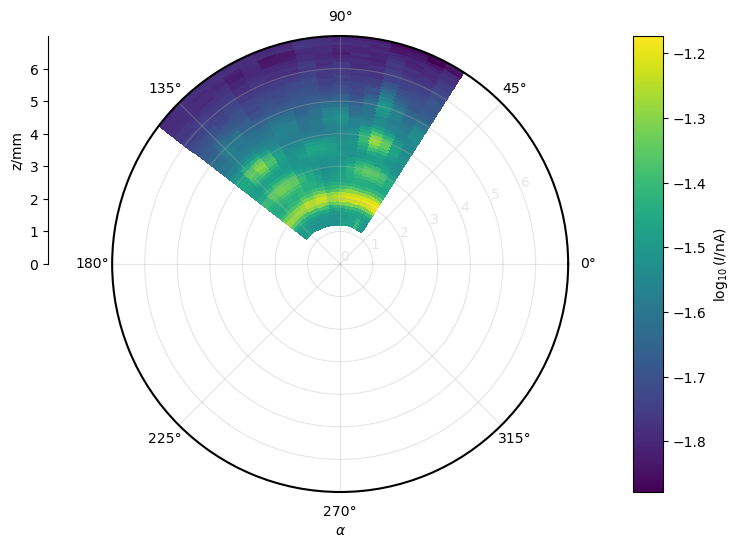

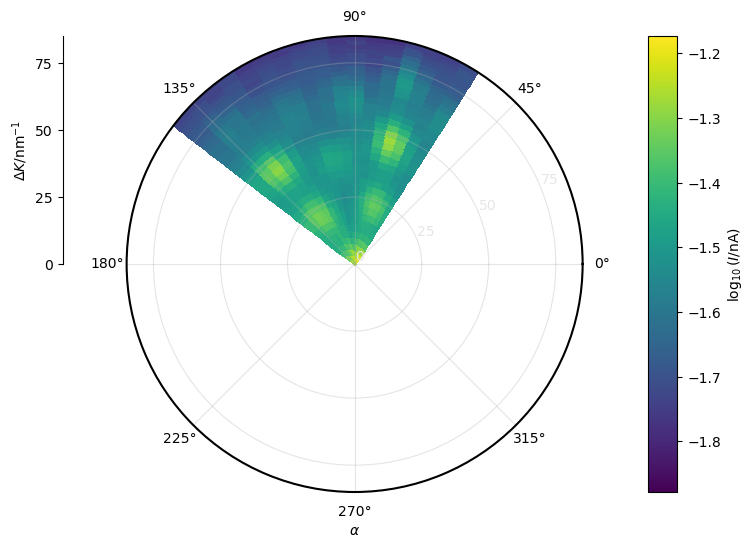

In [2]:
path_name = 'data/2023_11_defect2_MoS2_5um_hbn_sub'

z_zero = 1.3e6
file_ind=[43, 42, 41, 40, 39, 38, 37, 36, 35, 45, 46, 47, 49, 50, 51, 52, 53]
z_zero=np.linspace(1.24, 1.37, 17)*1e6

d = ssp.SpotProfile.import_ashem(file_ind, path_name, z_zero = z_zero)

d.normliase_scans()
d.shem_raw_plot()
d.shem_diffraction_plot()

## Principle azimuths

Identify one of the principle azimuths as $\alpha=75^\circ$ 

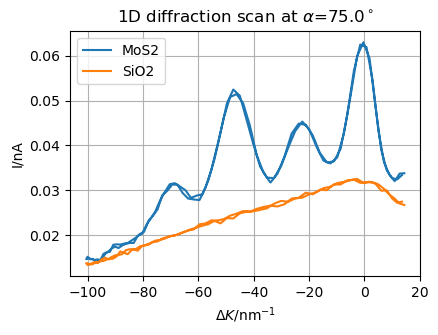

In [3]:
f, a, _ = d.line_plot_diffraction(75, scan=0, label='MoS2')
_, _, sio2_background = d.line_plot_diffraction(75, scan=2, label='SiO2', ax=a)

## Full/interpolated plot

Wrap around a $60^\circ$ slice of the scan to produce a full 2D scan. Also generate an interpolated plot (mapped from the radial grid that the data was originally taken on onto a rectangular grid).

/home/sam/repositories/mos2-defects/SHeM_diffraction_analysis/shem_spot_profile.py:1080: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh1 = ax1.pcolormesh(sP.alpha*pi/180, getattr(sP, var), Z,


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Interpolated k-plot, method = cubic'}, xlabel='$k_x/\\mathrm{nm}^{-1}$', ylabel='$k_y/\\mathrm{nm}^{-1}$'>,
 <matplotlib.collections.QuadMesh at 0x7a7ee9b25a90>)

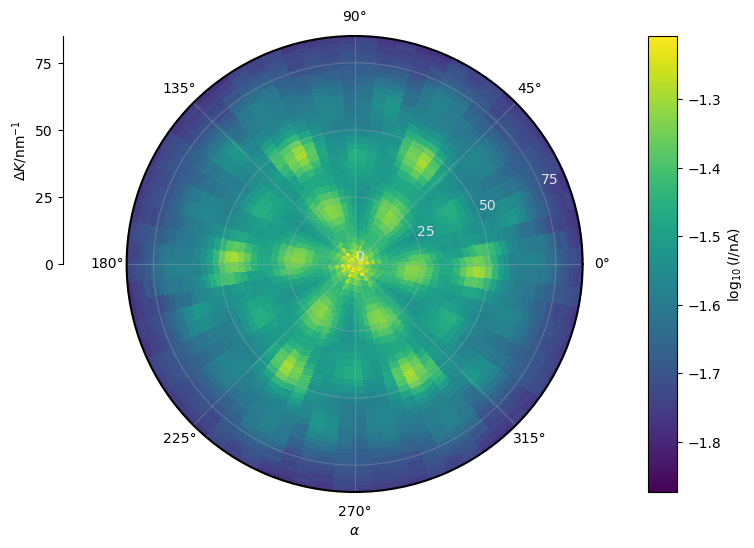

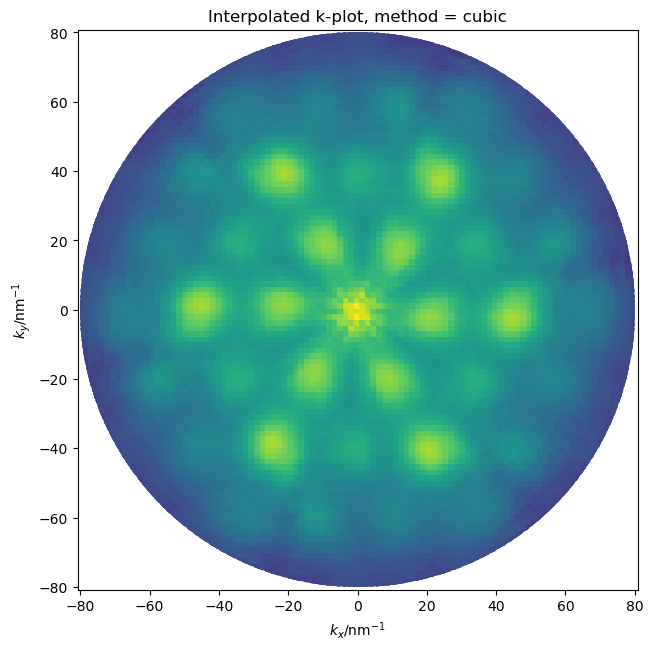

In [4]:
d_360 = d.wrap_around(60.0, crop=4)
d_360.set_alpha_zero(13)
d_360.calc_dK()
d_360.shem_diffraction_plot()
d_360_filtered = d_360.filter_by_var('DK', 0, 'below')
d_360_filtered.interpolated_plot(method='cubic')

/tmp/ipykernel_71239/3864035126.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',


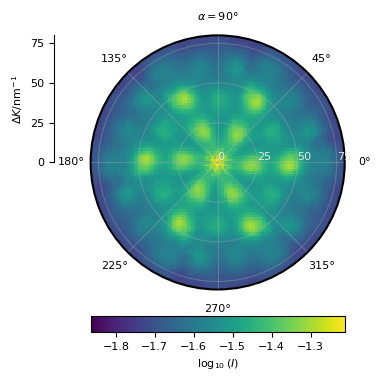

In [5]:
plt.rcParams["axes.axisbelow"] = True
plt.rc('font', size=8)
maxK = 80

I, kx, ky = d_360_filtered.grid_interpolate([-80, 80], [-80, 80], method='cubic')

f = plt.figure(figsize=[3.3,3.9])
gs = f.add_gridspec(2,1, height_ratios=[10,0.6], wspace=0, left=0.11, right=0.88, top=0.9, bottom=0.14)
rect  = [0.15, 0.1, 0.7, 0.9]
a=plt.subplot(gs[0], aspect=1.)
axc = plt.subplot(gs[1])
im = a.pcolormesh(kx, ky, np.log10(I), rasterized=True)
patch = patches.Circle((0, 0), radius = maxK, transform = a.transData)
im.set_clip_path(patch)
a.set_xlim(-maxK, maxK)
a.set_ylim(-maxK, maxK)
plt.grid(True)
ax_polar = f.add_axes(a.get_position(), polar=True, frameon=False, xticks=([]), yticks=([]))
ax_polar.set_yticks(np.array([0, 25, 50, 75])/maxK)
ax_polar.set_yticklabels(['0', '25', '50', '75']) #no radial ticks
a.set_axis_off()
a.set_title('')
ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',
                          '225°', '270°', '315°'])
ax_polar.set_rlabel_position(0)
ax_polar.grid(alpha=0.33)
ax_polar.tick_params(axis='y', colors=[0.9,0.9,0.9])
circle = plt.Circle((0, 0), radius=maxK, fill = False, linewidth=1.5, clip_on=False)
a.add_artist(circle)
scale_ax = ssp.add_scale(ax_polar, label = '$\\Delta K/\\mathrm{nm}^{-1}$', x_offset=0.11)
scale_ax.set_yticks(np.array([0, 25, 50, 75])/maxK)
scale_ax.set_yticklabels(['0', '25', '50', '75'])
f.colorbar(im, cax=axc, label="$\\log_{10}(I)$", orientation = 'horizontal')

## Background signal

To produce plots of two samples on the same colour scale we need to normalise the intensities. We will sse the SiO<sub>2</sub> substrate signal to normalise, allowing for a change in detector sensitivity and background. Load in the specific line scan that we use for normalisation.

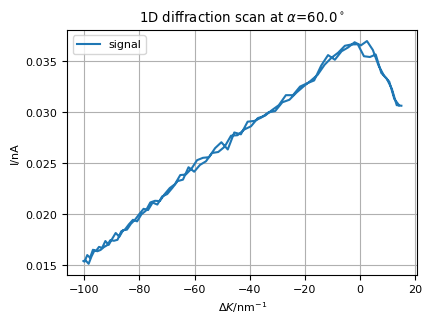

In [6]:
# This is the scan that the normalisation was done against
_, _, df_s3_norm = d.line_plot_diffraction(60, scan=2)

# Save for later
df_s3_norm.to_csv("sio_background.csv")

## Pristine sample data

Load in the data from the pristine sample.

Normalising against alpha = 90.0


/home/sam/repositories/mos2-defects/SHeM_diffraction_analysis/shem_spot_profile.py:1080: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh1 = ax1.pcolormesh(sP.alpha*pi/180, getattr(sP, var), Z,


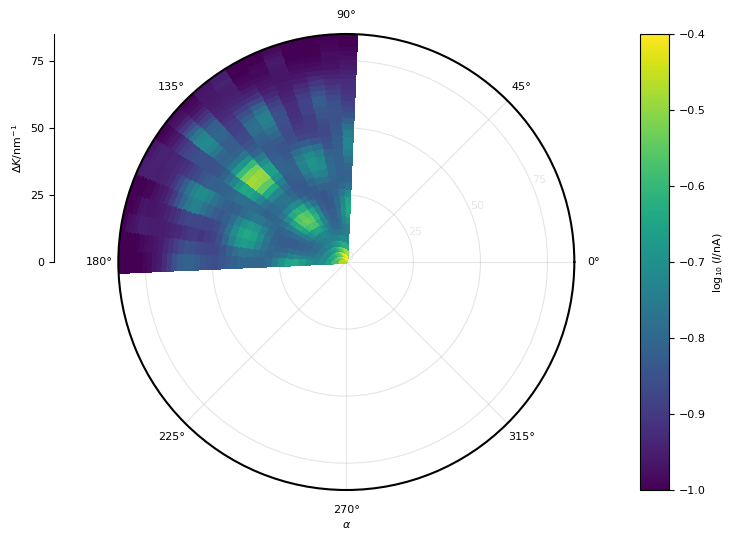

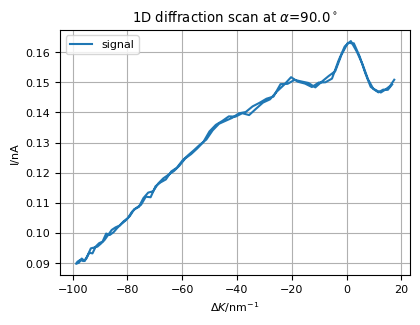

In [7]:
path_name='data/2023_12_defect1_repeat_5um_hbn_sub'

file_ind=[133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151]
angles = np.linspace(70,425,72)

z_zero = [1.2e6]
z_zero=np.linspace(1.08, 1.32, 19)*1e6
d1 = ssp.SpotProfile.import_ashem(file_ind, path_name, z_zero = z_zero, alphas=angles)

d1_2 = copy.deepcopy(d1)
d1_2.normliase_scans(data_scan=0, background_scan=1)
d1_2.shem_diffraction_plot(vmin=-1, vmax=-0.4)

# Background (SiO2) signal for normalising the signal
_, _, df_s1a_norm = d1.line_plot_diffraction(90, scan=1)

## Normalise to plot on the same colour scale

We need to normalise the two dataset onto the same colour scale so that they can be compared. To do this I allow the background and sensitivity to vary and match the signals from the SiO2 substrate.

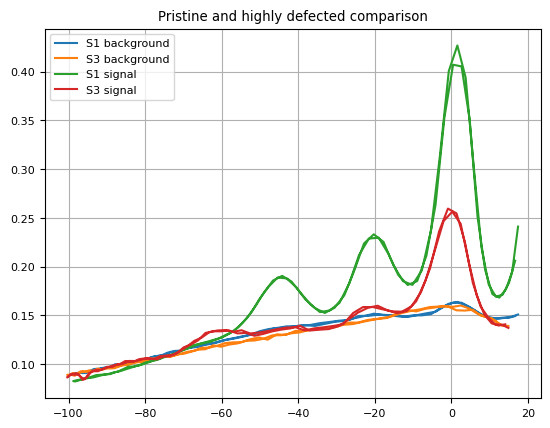

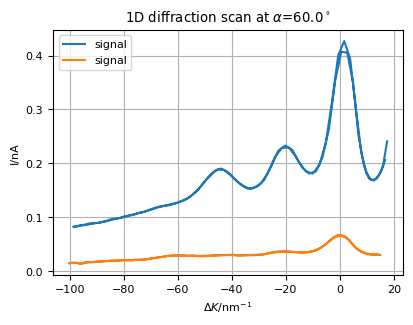

In [8]:
# Comparitive line plot
f, a = plt.subplots()
a.plot(df_s1a_norm['DK'], df_s1a_norm['signal'], label='S1 background')
# Add a scaling factor to roughly match the backgrounds
a.plot(df_s3_norm['DK'], df_s3_norm['signal']*3.3 + 0.038, label='S3 background')

# Extract data as data frames
_, ax, df_s1a_mos2 = d1.line_plot_diffraction(90, scan=0)
_, _, df_s3_mos2 = d.line_plot_diffraction(60, scan=0, ax=ax)

# Contine with comparitive plot
a.plot(df_s1a_mos2['DK'], df_s1a_mos2['signal'], label='S1 signal')
a.plot(df_s3_mos2['DK'], df_s3_mos2['signal']*3.3 + 0.038, label='S3 signal')
a.legend()
a.set_title("Pristine and highly defected comparison")
a.grid(True)

We are seeing 3.3 times more detector sensitivity with sample 1a than sample 3. Also the background signal is + 0.038nA more for sample 1. We apply this scaling to the main signal so we can create the two 2D plots on the same colour scale.

## Create the 2D plots

Create the 2 2D plots for the manuscript.

/tmp/ipykernel_71239/926977553.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',


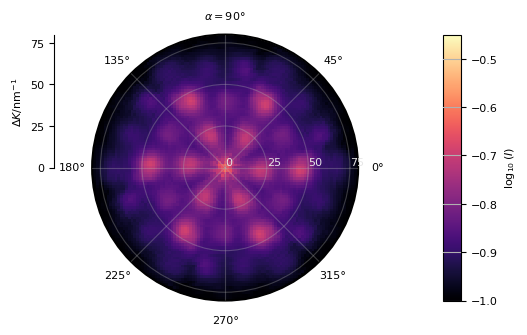

In [9]:
plt.rcParams["axes.axisbelow"] = False
plt.rc('font', size=8)
maxK = 80

I, kx, ky = d_360_filtered.grid_interpolate([-80, 80], [-80, 80], method='cubic')
I = I*3.3 + 0.038 # Normalisation factor (see above)

f = plt.figure(figsize=[5.4,3.5])
gs = f.add_gridspec(1,2, width_ratios=[10,0.5], wspace=0.2, left=0.11, right=0.88, top=0.9, bottom=0.14)

a=plt.subplot(gs[0], aspect=1.)
axc = plt.subplot(gs[1])
im = a.pcolormesh(kx, ky, np.log10(I), rasterized=True, clim=[-1, -0.45], cmap='magma')
patch = patches.Circle((0, 0), radius = maxK, transform = a.transData)
im.set_clip_path(patch)
a.set_xlim(-maxK, maxK)
a.set_ylim(-maxK, maxK)
plt.grid(True)
ax_polar = f.add_axes(a.get_position(), polar=True, frameon=False, xticks=([]), yticks=([]))
ax_polar.set_yticks(np.array([0, 25, 50, 75])/maxK)
ax_polar.set_yticklabels(['0', '25', '50', '75']) #no radial ticks
a.set_axis_off()
a.set_title('')
ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',
                          '225°', '270°', '315°'])
ax_polar.set_rlabel_position(0)
ax_polar.grid(alpha=0.33)
ax_polar.tick_params(axis='y', colors=[0.9,0.9,0.9])
circle = plt.Circle((0, 0), radius=maxK, fill = False, linewidth=1.5, clip_on=False)
a.add_artist(circle)
scale_ax = ssp.add_scale(ax_polar, label = '$\\Delta K/\\mathrm{nm}^{-1}$', x_offset=0.07)
scale_ax.set_yticks(np.array([0, 25, 50, 75])/maxK)
scale_ax.set_yticklabels(['0', '25', '50', '75'])
f.colorbar(im, cax=axc, label="$\\log_{10}(I)$", orientation = 'vertical')
plt.savefig(out_dir + '/sample3_2D_scale.pdf', dpi=450)
plt.savefig(out_dir + '/sample3_2D_scale.svg', dpi=450)
plt.savefig(out_dir + '/sample3_2D_scale.png', dpi=450)

/tmp/ipykernel_71239/1536618994.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',


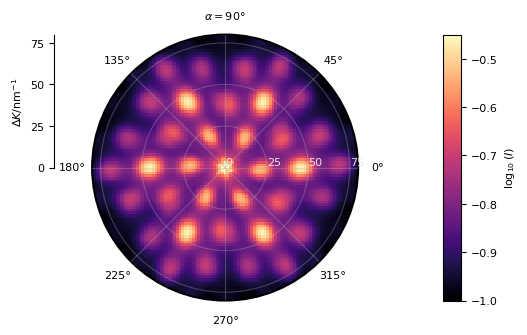

In [10]:
d1_2.set_alpha_zero(5)
d_360_1 = d1_2.wrap_around(60.0, crop=4)
d_360_1.set_alpha_zero(13)
d_360_1.calc_dK()
d_360_filtered_1 = d_360_1.filter_by_var('DK', 0, 'below')

plt.rcParams["axes.axisbelow"] = True
plt.rc('font', size=8)
maxK = 80

I, kx, ky = d_360_filtered_1.grid_interpolate([-80, 80], [-80, 80], method='cubic')
I = I

f = plt.figure(figsize=[5.4,3.5])
gs = f.add_gridspec(1,2, width_ratios=[10,0.5], wspace=0.2, left=0.11, right=0.88, top=0.9, bottom=0.14)

a=plt.subplot(gs[0], aspect=1.)
axc = plt.subplot(gs[1])
im = a.pcolormesh(kx, ky, np.log10(I), rasterized=True, clim=[-1, -0.45], cmap='magma')
patch = patches.Circle((0, 0), radius = maxK, transform = a.transData)
im.set_clip_path(patch)
a.set_xlim(-maxK, maxK)
a.set_ylim(-maxK, maxK)
plt.grid(True)
ax_polar = f.add_axes(a.get_position(), polar=True, frameon=False, xticks=([]), yticks=([]))
ax_polar.set_yticks(np.array([0, 25, 50, 75])/maxK)
ax_polar.set_yticklabels(['0', '25', '50', '75']) #no radial ticks
a.set_axis_off()
a.set_title('')
ax_polar.set_xticklabels(['0°', '45°', '$\\alpha=90$°', '135°', '180°',
                          '225°', '270°', '315°'])
ax_polar.set_rlabel_position(0)
ax_polar.grid(alpha=0.33)
ax_polar.tick_params(axis='y', colors=[0.9,0.9,0.9])
circle = plt.Circle((0, 0), radius=maxK, fill = False, linewidth=1.5, clip_on=False)
a.add_artist(circle)
scale_ax = ssp.add_scale(ax_polar, label = '$\\Delta K/\\mathrm{nm}^{-1}$', x_offset=0.07)
scale_ax.set_yticks(np.array([0, 25, 50, 75])/maxK)
scale_ax.set_yticklabels(['0', '25', '50', '75'])
f.colorbar(im, cax=axc, label="$\\log_{10}(I)$", orientation = 'vertical')
plt.savefig(out_dir + '/sample1a_2D_scale.pdf', dpi=450)
plt.savefig(out_dir + '/sample1a_2D_scale.svg', dpi=450)
plt.savefig(out_dir + '/sample1a_2D_scale.png', dpi=450)